In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import numpy as np

file_path = './test_files/3Dblood 26.11.txt'
df = pd.read_csv(file_path, header=None)
df.columns = ['x', 'y', 'z', 'r', 'g', 'b']
df

,x,y,z,r,g,b
0,4.275980,11.059498,3.185819,255,0,255
1,4.295052,11.128907,3.116422,255,0,255
2,4.260648,10.636221,3.608462,255,0,255
3,4.253031,10.706822,3.538061,255,0,255
4,4.324351,10.356519,3.886832,255,0,255
...,...,...,...,...,...,...
1919,4.000000,11.197390,3.047941,0,255,0
1920,4.200000,11.197390,3.047941,0,255,0
1921,4.100000,11.197390,3.047941,0,255,0
1922,4.300000,11.197390,3.047941,0,255,0


In [60]:
def distance_calculator(df):
    # Drop NaN values (usually the first value)
    dx = df['x'].diff()
    dy = df['y'].diff()
    dz = df['z'].diff()

    # Calculate the Euclidean distance between consecutive rows
    distances = np.sqrt(dx**2 + dy**2 + dz**2)
    df['distance_from_last'] = distances
    return df

def remove_overlap(shape):
    # Checks for any large jumps at the end of a line and, if found, moves the last row to the top
    # This hopefully removed the jump and makes the line continuous
    if shape.iloc[-1]['distance_from_last'] > 1.:
        # Move the last row to the top
        last_row = shape.iloc[[-1]]  # Select the last row as a DataFrame
        remaining_rows = shape.iloc[:-1]  # Select all rows except the last
        shape = pd.concat([last_row, remaining_rows]).reset_index(drop=True)

    shape = distance_calculator(shape)
    return shape

df = distance_calculator(df)
df['line_id'] = pd.factorize(df[['r','g','b']].apply(tuple, axis=1))[0]
df = df.groupby('line_id', group_keys=False).apply(remove_overlap)
df = distance_calculator(df)

# Next bit is to use hierarchical clustering to note common start / end points
# Gather the first and last points of each line:
from scipy.spatial import distance as dist
import scipy.cluster.hierarchy as hier
start_points = df.groupby('line_id', group_keys=False).first()  # First point of each line
end_points = df.groupby('line_id', group_keys=False).last()  # Last
terminal_points = pd.concat([start_points, end_points])   
dist_mat = dist.pdist(terminal_points[['x', 'y', 'z']].values)   
link_mat = hier.linkage(dist_mat)
# fcluster assigns each of the particles in positions a cluster to which it belongs
cluster_idx = hier.fcluster(link_mat, 1, criterion='distance')


In [61]:
df

,x,y,z,r,g,b,distance_from_last,line_id
0,4.275980,11.059498,3.185819,255,0,255,NaN,0
1,4.295052,11.128907,3.116422,255,0,255,0.099987,0
2,4.260648,10.636221,3.608462,255,0,255,0.697156,0
3,4.253031,10.706822,3.538061,255,0,255,0.099995,0
4,4.324351,10.356519,3.886832,255,0,255,0.499439,0
...,...,...,...,...,...,...,...,...
1919,4.000000,11.197390,3.047941,0,255,0,0.100000,7
1920,4.200000,11.197390,3.047941,0,255,0,0.200000,7
1921,4.100000,11.197390,3.047941,0,255,0,0.100000,7
1922,4.300000,11.197390,3.047941,0,255,0,0.200000,7


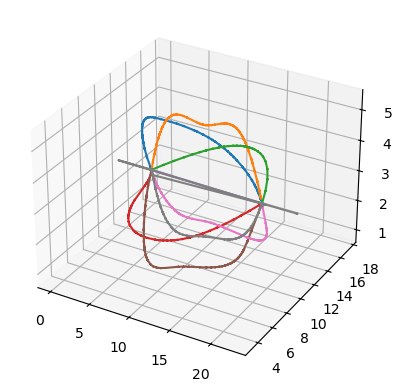

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for n in np.unique(df['line_id'].values):
    ax.plot(df[df['line_id'] == n]['x'], df[df['line_id'] == n]['y'], df[df['line_id'] == n]['z'])

plt.show()



In [20]:
def determine_style(row):
    # capillaries
    if row['b'] > 0:
        return 2
    # venules
    elif row['g'] > 0:
        return 5
    # veins 
    elif row['r'] > 0:
        return 8 
    else:
        return 1

def thickness_to_radius(thickness):
    # Assuming radius is proportional to thickness
    return thickness / 2

# Apply determine_style to get thickness
df['thickness'] = df.apply(determine_style, axis=1)

# Convert thickness to radius3
df['radius'] = df['thickness'].apply(thickness_to_radius)

df['e'] = np.pi * df['radius']**2 * df['distance_to_next']

df

,x,y,z,r,g,b,distance_to_next,thickness,radius,e
0,0.900000,0.000000,0.0,200,0,0,NaN,8,4.0,NaN
1,1.000000,0.000000,0.0,200,0,0,0.100000,8,4.0,5.026548
2,-0.900000,0.000000,0.0,200,0,0,1.900000,8,4.0,95.504417
3,-1.000000,0.000000,0.0,200,0,0,0.100000,8,4.0,5.026548
4,0.639206,-0.316260,0.0,0,255,0,1.669435,5,2.5,32.779289
...,...,...,...,...,...,...,...,...,...,...
190,-0.087749,-0.012726,0.0,0,0,255,0.014130,2,1.0,0.044391
191,-0.100991,-0.006839,0.0,0,0,255,0.014491,2,1.0,0.045526
192,-0.114177,0.000032,0.0,0,0,255,0.014869,2,1.0,0.046712
193,-0.127244,0.007937,0.0,0,0,255,0.015272,2,1.0,0.047979


In [21]:
def generate_gcode(df):
    gcode_lines = []

    # Define some starting commands if necessary
    gcode_lines.append("G21 ; Set units to millimeters")
    gcode_lines.append("G90 ; Absolute positioning")
    
    for index, row in df.iterrows():
        # Move to the start position
        gcode_lines.append(f"G0 X{row['x']} Y{row['y']} Z{row['z']} ; Move to start position")
        
        # Example of drawing or other operation
        # For simplicity, let's assume 'e' is used for setting extrusion or other properties
        gcode_lines.append(f"G1 E{row['e']} ; Set extrusion amount")
        
        # Move to another position or perform an action (for demonstration)
        gcode_lines.append(f"G1 X{row['x']+5} Y{row['y']} Z{row['z']} ; Move to another position")
    
    # Add end commands if necessary
    gcode_lines.append("M30 ; End of program")

    return "\n".join(gcode_lines)

# Generate the G-code
gcode = generate_gcode(df)

# Save to a file
with open("output.gcode", "w") as file:
    file.write(gcode)